In [156]:
import geopandas as gpd
import os
import pandas as pd
import yaml
import numpy as np
from shapely.geometry import Point

In [157]:
nodes = gpd.read_file("/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/derived_data/regions/provinces_onshore.geojson")
# nodes_offshore = gpd.read_file("/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/derived_data/regions/provinces_offshore.geojson")
# nodes.dropna(how="all", axis=1, inplace=True)
t = "/home/ivanra/documents/tmp-pypsa-china/PyPSA-China-PIK/resources/data/existing_infrastructure/Global-Coal-Plant-Tracker-July-2023.xlsx"


In [158]:
import logging
logger = logging.getLogger("devgem")

In [ ]:
import requests
import zipfile
import io

def fetch_gadm(country_code="CHN", level=2):
    """
    fetch GADM shapefile for a given country and administrative level.
    https://gadm.org/download_country.html

    Parameters:
        country_code (str): ISO3 country code (e.g., 'CHN', 'USA').
        level (int): Administrative level (0=country, 1=region, etc.).

    Returns:
        geopandas.GeoDataFrame: Loaded shapefile as GeoDataFrame.
    """
    # Construct the URL
    url = f"https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_{country_code}_shp.zip"

    # Download the zip file
    response = requests.get(url)
    if response.status_code != 200:
        raise ValueError(
            f"Failed to download data for {country_code} - Status code: {response.status_code}"
        )

    # Extract the zip file in memory
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Filter to the desired level shapefile
        level_filename = f"gadm41_{country_code}_{level}.shp"
        if level_filename not in z.namelist():
            raise ValueError(f"Level {level} shapefile not found for {country_code}.")

        shp_dir = "resources/data/province_shapes"
        z.extractall(shp_dir)
        gdf = gpd.read_file(f"{shp_dir}/{level_filename}")
        return gdf


def fetch_prefecture_shapes(
    fixes={
        "NAME_1": {
            "Nei Mongol": "InnerMongolia",
            "Xinjiang Uygur": "Xinjiang",
            "Hong Kong": "HongKong",
        }
    }
):
    """
    Fetch county-level shapefiles for China.

    Args:
        fixes (dict, Optional): Dictionary mapping old names to new names for specific columns.
    """
    gdf = fetch_gadm(country_code="CHN", level=2)
    for col, fix_dict in fixes.items():
        for old_name, new_name in fix_dict.items():
            mask = gdf.query(f"{col} == '{old_name}'").index
            gdf.loc[mask, col] = new_name
    return gdf


def build_provinces_with_split_inner_mongolia(
    prefectures: gpd.GeoDataFrame,
    east_prefs=["Hulunbuir", "Xing'an", "Tongliao", "Chifeng", "Xilin Gol"],
    west_prefs=[
        "Alxa",
        "Baotou",
        "Baynnur",
        "Hohhot",
        "Ordos",
        "Ulaan Chab",
        "Wuhai",
    ],
) -> gpd.GeoDataFrame:
    """
    Split Inner Mongolia into East and West regions based on predefined prefectures.

    Args:
        prefectures (gpd.GeoDataFrame): Gall chinese prefectures.
        east_prefs (list, optional): List of prefectures in Inner Mongolia East.
        west_prefs (list, optional): List of prefectures in Inner Mongolia West.
    Returns:
        gpd.GeoDataFrame: Updated GeoDataFrame with Inner Mongolia split EAST/WEST.
    """
    gdf = prefectures.copy()
    
    if not (set(east_prefs) & set(west_prefs) == set()):
        raise ValueError("East and West prefecture lists must not overlap.")
    all_prefs = sorted(east_prefs + west_prefs)
    if not all_prefs == sorted(gdf.query("NAME_1 == 'InnerMongolia'").NAME_2.unique().tolist()):
        raise ValueError(
            f"Inner Mongolia prefectures do not match expected: \n{all_prefs}\n vs\n {gdf.query('NAME_1 == \"InnerMongolia\"').NAME_2.unique().tolist()}"
        )
    split = {
        prefecture: "InnerMongoliaEast" if prefecture in east_prefs else "InnerMongoliaWest"
        for prefecture in gdf.query("NAME_1 == 'InnerMongolia'").NAME_2
    }
    mask = gdf.query("NAME_1 == 'InnerMongolia'").index
    gdf.loc[mask, "NAME_1"] = gdf.loc[mask, "NAME_2"].map(split)
    return gdf.dissolve(by="NAME_1", aggfunc="sum")



In [176]:
prefs = fetch_prefecture_shapes()


In [169]:
prefs.query("NAME_1=='InnerMongolia'").NAME_2.unique()

array(['Alxa', 'Baotou', 'Baynnur', 'Chifeng', 'Hohhot', 'Hulunbuir',
       'Ordos', 'Tongliao', 'Ulaan Chab', 'Wuhai', 'Xilin Gol', "Xing'an"],
      dtype=object)

In [175]:
provinces = split_inner_mongolia(prefs)

ValueError: Inner Mongolia prefectures do not match expected: 
['Alxa', 'Baotou', 'Baynnur', 'Chifeng', 'Hohhot', 'Hulunbuir', 'Ordos', 'Tongliao', 'Ulaan Chab', 'Wuhai', 'Xilin Gol', "Xing'an"]
 vs
 []

In [159]:
def load_gem_excel(path: os.PathLike, sheetname = "Units", country_names = ["China"])-> pd.DataFrame:
    """
    Load a Global Energy monitor excel file as a dataframe.

    Args:
        path (os.PathLike): Path to the Excel file.
        sheetname (str): Name of the sheet to load. Default is "Units".
        country_names (list): List of country names to filter by. Default is ["China"].
    """

    df = pd.read_excel(path, sheet_name=sheetname, engine="openpyxl")
    return df.query('Country in @country_names')

def partition_gem_across_nodes(gem_data: pd.DataFrame, nodes: gpd.GeoDataFrame, admin_level = None) -> pd.DataFrame:
    """
    Partition GEM data across nodes based on geographical coordinates.

    Args:
        gem_data (pd.DataFrame): DataFrame containing GEM data.
        nodes (geopandas.GeoDataFrame): GeoDataFrame containing node geometries (nodes as index).
        admin_level (int, optional): Administrative level for partitioning. Default is None (GPS).

    Returns:
        pd.DataFrame: DataFrame with GEM data partitioned across nodes.
    """
    ADM_COL = {0:"Country", 1:'Subnational unit (province, state)', 2: 'Major area (prefecture, district)'}
    if admin_level is not None and admin_level not in [0, 1, 2]:
        raise ValueError("admin_level must be None, 0, 1, or 2")

    # snap to admin_level
    if admin_level is not None:
        admin = ADM_COL[admin_level]
        gem_data[admin] = gem_data[admin].str.replace(" ", "")
        uncovered_gem = set(gem_data[ADM_COL[admin_level]]) - set(nodes.index)
        if uncovered_gem:
            logger.warning(
                f"Some GEM locations are not covered by the nodes at admin level {admin_level}: {uncovered_gem}"
                ". Consider partitioning with at a different admin_level or with GPS (None)."
            )
        gem_data["node"] = gem_data[admin]
        gem_data.dropna(subset=["node"], inplace=True)
        return gem_data
    else:
        gem_data["geometry"] = gem_data.apply(
            lambda row: Point(row["Longitude"], row["Latitude"]), axis=1
        )
        gem_gdf = gpd.GeoDataFrame(gem_data, geometry="geometry", crs="EPSG:4326")
        gem_gdf = gem_gdf.to_crs(nodes.crs)
        joined = nodes.reset_index(names="node").sjoin_nearest(gem_gdf, how="right")
        missing = joined[joined.node.isna()]
        if not missing.empty:
            logger.warning(
                f"Some GEM locations are not covered by the nodes at GPS: {missing["Plant name"].head()}"
            )
        return joined


In [160]:
df = load_gem_excel(t, sheetname="Units", country_names=["China"])
nodes.set_index("province", inplace=True)

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


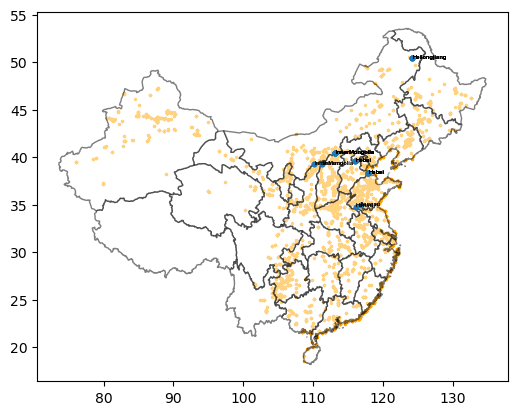

In [161]:
df["Subnational unit (province, state)"] = df["Subnational unit (province, state)"].str.replace(" ", "")
joined = partition_gem_across_nodes(df, nodes, admin_level=None)
unmatched = joined[joined.node != joined["Subnational unit (province, state)"]]
ax = joined[joined.node == joined["Subnational unit (province, state)"]].plot(markersize=2, color ="orange")
nodes.plot(ax=ax, color="white", markersize=1, alpha=0.5, edgecolor='black')
unmatched.plot(markersize=10, ax =ax)
# Annotate unmatched points based on column "a"
col = "Subnational unit (province, state)"
if col in unmatched.columns:
    for idx, row in unmatched.iterrows():
        ax.annotate(str(row[col]), (row.geometry.x, row.geometry.y), fontsize=4, color="black")

In [ ]:
cols = ['node','Subnational unit (province, state)', "geometry", "Location", 'Plant name', 'Capacity (MW)', 'Owner', 'Parent', 'Coal source', 'Heat rate (Btu per kWh)', 'Emission factor (kg of CO2 per TJ)',
       'Capacity factor' ]
unmatched[cols]

,node,"Subnational unit (province, state)",geometry,Location,Plant name,Capacity (MW),Owner,Parent,Coal source,Heat rate (Btu per kWh),Emission factor (kg of CO2 per TJ),Capacity factor
1559,Shanxi,InnerMongolia,POINT (113.14516 40.40519),Xinying,Fengzhen power station,200.0,Inner Mongolia Mengdian Huaneng Thermal Power ...,Inner Mongolia MengDian HuaNeng Thermal Power ...,NaN,12183,94600,0.53
1560,Shanxi,InnerMongolia,POINT (113.14516 40.40519),Xinying,Fengzhen power station,200.0,Inner Mongolia Mengdian Huaneng Thermal Power ...,Inner Mongolia MengDian HuaNeng Thermal Power ...,NaN,12183,94600,0.53
1561,Shanxi,InnerMongolia,POINT (113.14516 40.40519),Xinying,Fengzhen power station,200.0,Inner Mongolia Mengdian Huaneng Thermal Power ...,Inner Mongolia MengDian HuaNeng Thermal Power ...,NaN,12618,94600,0.53
1562,Shanxi,InnerMongolia,POINT (113.14516 40.40519),Xinying,Fengzhen power station,200.0,Inner Mongolia Mengdian Huaneng Thermal Power ...,Inner Mongolia MengDian HuaNeng Thermal Power ...,NaN,12618,94600,0.53
1563,Shanxi,InnerMongolia,POINT (113.14516 40.40519),Xinying,Fengzhen power station,200.0,Inner Mongolia Mengdian Huaneng Thermal Power ...,Inner Mongolia MengDian HuaNeng Thermal Power ...,NaN,12183,94600,0.53
1564,Shanxi,InnerMongolia,POINT (113.14516 40.40519),Xinying,Fengzhen power station,200.0,Inner Mongolia Mengdian Huaneng Thermal Power ...,Inner Mongolia MengDian HuaNeng Thermal Power ...,NaN,12183,94600,0.53
2107,Shandong,Hebei,POINT (117.87861 38.31),Xincun Town,Hebei Cangdong power station,600.0,Hebei Guohua Cangdong Power Plant,China Shenhua Energy Co Ltd [51.0%]; Hebei Con...,NaN,9572,94600,0.53
2108,Shandong,Hebei,POINT (117.87861 38.31),Xincun Town,Hebei Cangdong power station,600.0,Hebei Guohua Cangdong Power Plant,China Shenhua Energy Co Ltd [51.0%]; Hebei Con...,NaN,9572,94600,0.53
2109,Shandong,Hebei,POINT (117.87861 38.31),Xincun Town,Hebei Cangdong power station,660.0,Hebei Guohua Cangdong Power Plant,China Shenhua Energy Co Ltd [51.0%]; Hebei Con...,NaN,9250,94600,0.53
2110,Shandong,Hebei,POINT (117.87861 38.31),Xincun Town,Hebei Cangdong power station,660.0,Hebei Guohua Cangdong Power Plant,China Shenhua Energy Co Ltd [51.0%]; Hebei Con...,NaN,9250,94600,0.53


In [163]:

pd.set_option('display.max_', None)

OptionError: Pattern matched multiple keys

In [ ]:
countries_names = ["CHA"]

def replace_natural_gas_technology(df: pd.DataFrame):
    """
    Maps and replaces gas technologies in the powerplants.csv onto model
    compliant carriers.
    """
    mapping = {
        "Steam Turbine": "CCGT",
        "Combustion Engine": "OCGT",
        "NG": "CCGT",
        "Ng": "CCGT",
        "NG/FO": "OCGT",
        "Ng/Fo": "OCGT",
        "NG/D": "OCGT",
        "LNG": "OCGT",
        "CCGT/D": "CCGT",
        "CCGT/FO": "CCGT",
        "LCCGT": "CCGT",
        "CCGT/Fo": "CCGT",
    }
    fueltype = df["Fueltype"] == "Natural Gas"
    df.loc[fueltype, "Technology"] = (
        df.loc[fueltype, "Technology"].replace(mapping).fillna("CCGT")
    )
    unique_tech_with_ng = df.loc[fueltype, "Technology"].unique()
    unknown_techs = np.setdiff1d(unique_tech_with_ng, ["CCGT", "OCGT"])
    if len(unknown_techs) > 0:
        df.loc[fueltype, "Technology"] = df.loc[fueltype, "Technology"].replace(
            {t: "CCGT" for t in unknown_techs}
        )
    df["Fueltype"] = np.where(fueltype, df["Technology"], df["Fueltype"])
    return df


# ppl_raw = pm.powerplants(from_url=True, update=True, config_update=config)
   